In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from src.model import build_policy_table

np.random.seed(42)


In [39]:
policy_inputs = [
    {"Policy": "Baseline", "Y_TWh": 448, "C_g_per_kWh": 570},
    {"Policy": "Carbon Tax ($30/ton)", "Y_TWh": 403, "C_g_per_kWh": 513},
    {"Policy": "Clean Energy Subsidy", "Y_TWh": 480, "C_g_per_kWh": 412},
    {"Policy": "Dynamic Energy Pricing", "Y_TWh": 490, "C_g_per_kWh": 426},
    {"Policy": "Clean Energy Mandate (50%)", "Y_TWh": 480, "C_g_per_kWh": 500},
]

df_base = build_policy_table(policy_inputs)
df_base[["Policy", "Emissions_MMT"]]


,Policy,Emissions_MMT
0,Baseline,255.360
1,Carbon Tax ($30/ton),206.739
2,Clean Energy Subsidy,197.760
3,Dynamic Energy Pricing,208.740
4,Clean Energy Mandate (50%),240.000


In [40]:
def run_monte_carlo(policy_inputs, shock=0.10, n_sims=10000):

    rows = []

    for sim in range(n_sims):

        y_shock = np.random.normal(1, shock)
        c_shock = np.random.normal(1, shock)

        shocked_inputs = []

        for row in policy_inputs:
            shocked_inputs.append({
                "Policy": row["Policy"],
                "Y_TWh": row["Y_TWh"] * y_shock,
                "C_g_per_kWh": row["C_g_per_kWh"] * c_shock,
            })

        df_sim = build_policy_table(shocked_inputs)

        df_sim["Sim"] = sim

        rows.append(df_sim)

    return pd.concat(rows, ignore_index=True)


In [41]:
mc = run_monte_carlo(policy_inputs, shock=0.10, n_sims=10000)

mc.head()


,Policy,Y_TWh,C_g_per_kWh,Emissions_MMT,Abatement_MMT,Abatement_%,Sim
0,Baseline,470.253,562.119,264.338,0.000,0.000,0
1,Carbon Tax ($30/ton),423.018,505.907,214.008,50.330,19.040,0
2,Clean Energy Subsidy,503.842,406.304,204.713,59.625,22.556,0
3,Dynamic Energy Pricing,514.339,420.110,216.079,48.259,18.257,0
4,Clean Energy Mandate (50%),503.842,493.087,248.438,15.900,6.015,0


In [42]:
summary = (
    mc.groupby("Policy")["Emissions_MMT"]
    .agg(
        mean="mean",
        std="std",
        p5=lambda x: np.percentile(x, 5),
        p95=lambda x: np.percentile(x, 95),
    )
    .round(3)
)

summary["range_90pct"] = (summary["p95"] - summary["p5"]).round(3)

summary = summary.sort_values("mean")

summary


,mean,std,p5,p95,range_90pct
Policy,,,,,
Clean Energy Subsidy,197.979,28.093,153.297,245.251,91.954
Carbon Tax ($30/ton),206.968,29.369,160.258,256.387,96.129
Dynamic Energy Pricing,208.971,29.653,161.809,258.868,97.059
Clean Energy Mandate (50%),240.266,34.094,186.041,297.635,111.594
Baseline,255.643,36.276,197.947,316.684,118.737


In [43]:
baseline = mc[mc["Policy"] == "Baseline"][["Sim", "Emissions_MMT"]]
baseline = baseline.rename(columns={"Emissions_MMT": "Baseline_Emissions"})

merged = mc.merge(baseline, on="Sim")

merged["Beats_Baseline"] = merged["Emissions_MMT"] < merged["Baseline_Emissions"]

prob_beats = (
    merged[merged["Policy"] != "Baseline"]
    .groupby("Policy")["Beats_Baseline"]
    .mean()
    .round(3)
)

prob_beats


Policy
Carbon Tax ($30/ton)         1.000
Clean Energy Mandate (50%)   1.000
Clean Energy Subsidy         1.000
Dynamic Energy Pricing       1.000
Name: Beats_Baseline, dtype: float64

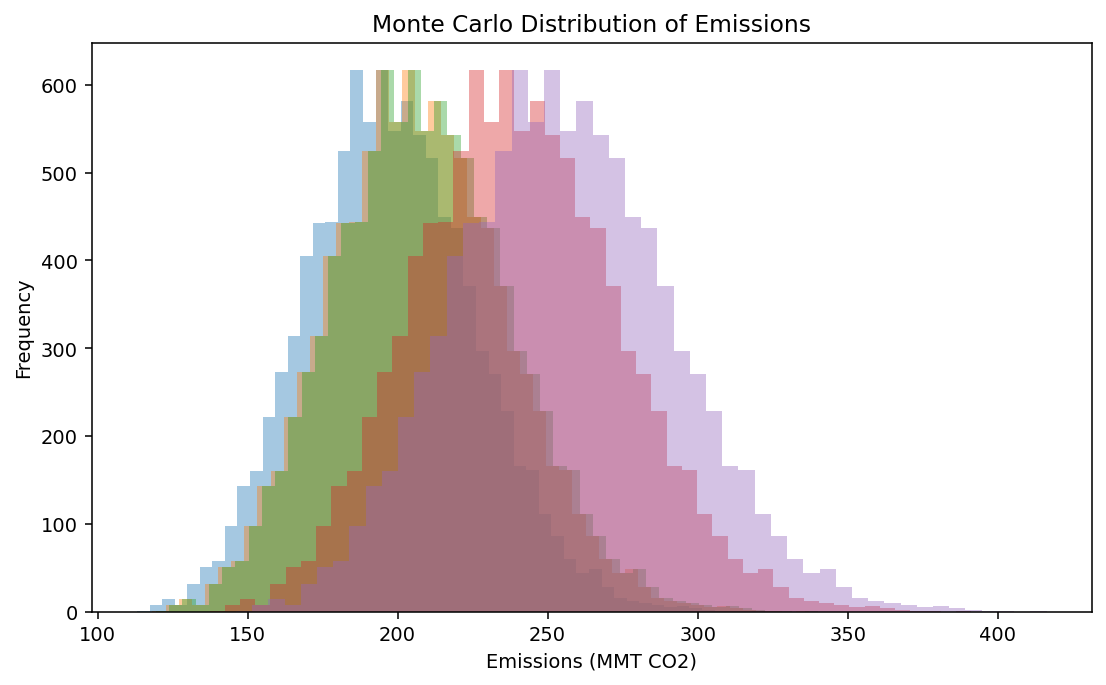

In [44]:
plt.figure(figsize=(8, 5))

for policy in summary.index:
    subset = mc[mc["Policy"] == policy]
    plt.hist(subset["Emissions_MMT"], bins=50, alpha=0.4)

plt.xlabel("Emissions (MMT CO2)")
plt.ylabel("Frequency")
plt.title("Monte Carlo Distribution of Emissions")
plt.tight_layout()
plt.show()


In [45]:
mc.columns


Index(['Policy', 'Y_TWh', 'C_g_per_kWh', 'Emissions_MMT', 'Abatement_MMT',
       'Abatement_%', 'Sim'],
      dtype='object')

In [46]:
baseline = mc.loc[mc["Policy"] == "Baseline", ["Sim", "Emissions_MMT"]].rename(
    columns={"Emissions_MMT": "Baseline_Emissions"}
)

merged = mc.merge(baseline, on="Sim", how="left")

prob_beats = (
    merged.loc[merged["Policy"] != "Baseline"]
    .assign(beats=lambda d: d["Emissions_MMT"] < d["Baseline_Emissions"])
    .groupby("Policy")["beats"]
    .mean()
    .sort_values(ascending=False)
    .round(3)
)

prob_beats


Policy
Carbon Tax ($30/ton)         1.000
Clean Energy Mandate (50%)   1.000
Clean Energy Subsidy         1.000
Dynamic Energy Pricing       1.000
Name: beats, dtype: float64

In [47]:
tail_risk = (
    mc.groupby("Policy")["Emissions_MMT"]
    .apply(lambda x: (x > 250).mean())
    .sort_values()
    .round(3)
)

tail_risk


Policy
Clean Energy Subsidy         0.037
Carbon Tax ($30/ton)         0.075
Dynamic Energy Pricing       0.086
Clean Energy Mandate (50%)   0.380
Baseline                     0.549
Name: Emissions_MMT, dtype: float64

In [48]:
baseline_mean = summary.loc["Baseline", "mean"]

expected_abatement = (baseline_mean - summary["mean"]).sort_values(ascending=False).round(3)

expected_abatement


Policy
Clean Energy Subsidy         57.664
Carbon Tax ($30/ton)         48.675
Dynamic Energy Pricing       46.672
Clean Energy Mandate (50%)   15.377
Baseline                      0.000
Name: mean, dtype: float64

In [49]:
# Wide format by simulation
mc_wide = mc.pivot(index="Sim", columns="Policy", values="Emissions_MMT")

# Abatement relative to baseline
abatement_wide = mc_wide["Baseline"].values.reshape(-1, 1) - mc_wide.values
abatement = pd.DataFrame(abatement_wide, columns=mc_wide.columns)
abatement.head()


Policy,Baseline,Carbon Tax ($30/ton),Clean Energy Mandate (50%),Clean Energy Subsidy,Dynamic Energy Pricing
0,0.000,50.330,15.900,59.625,48.259
1,0.000,59.655,18.846,70.672,57.200
2,0.000,46.371,14.649,54.934,44.462
3,0.000,60.620,19.151,71.815,58.125
4,0.000,48.853,15.433,57.874,46.842


In [50]:
policy_cost = {
    "Baseline": 0.00,
    "Carbon Tax ($30/ton)": -1.03,
    "Clean Energy Subsidy": -5.08,
    "Dynamic Energy Pricing": -4.72,
    "Clean Energy Mandate (50%)": -2.29,
}


In [51]:
cost_per_ton = {}

for policy in abatement.columns:
    if policy == "Baseline":
        continue

    cost = policy_cost[policy]  # in $ billions
    # convert billions to dollars, MMT to metric tons
    cost_dollars = cost * 1e9
    tons = abatement[policy] * 1e6

    cpt = cost_dollars / tons
    cost_per_ton[policy] = cpt

cost_per_ton = pd.DataFrame(cost_per_ton)
cost_per_ton.head()


,Carbon Tax ($30/ton),Clean Energy Mandate (50%),Clean Energy Subsidy,Dynamic Energy Pricing
0,-20.465,-144.025,-85.199,-97.805
1,-17.266,-121.513,-71.882,-82.518
2,-22.212,-156.323,-92.474,-106.157
3,-16.991,-119.578,-70.738,-81.204
4,-21.084,-148.382,-87.777,-100.764


In [52]:
cpt_summary = pd.DataFrame({
    "mean": cost_per_ton.mean(),
    "std": cost_per_ton.std(),
    "p5": cost_per_ton.quantile(0.05),
    "p95": cost_per_ton.quantile(0.95),
})

cpt_summary["range_90pct"] = cpt_summary["p95"] - cpt_summary["p5"]

cpt_summary = cpt_summary.round(2).sort_values("mean")

cpt_summary


,mean,std,p5,p95,range_90pct
Clean Energy Mandate (50%),-152.010,22.210,-192.330,-120.220,72.110
Dynamic Energy Pricing,-103.230,15.080,-130.610,-81.640,48.970
Clean Energy Subsidy,-89.920,13.140,-113.770,-71.120,42.660
Carbon Tax ($30/ton),-21.600,3.160,-27.330,-17.080,10.250


In [53]:
row_min = cost_per_ton.min(axis=1)
is_best = cost_per_ton.eq(row_min, axis=0)

prob_best = is_best.mean().sort_values(ascending=False).round(3)

prob_best


Clean Energy Mandate (50%)   1.000
Carbon Tax ($30/ton)         0.000
Clean Energy Subsidy         0.000
Dynamic Energy Pricing       0.000
dtype: float64